<h2 style="text-align:center;font-size:200%;;">Лабораторная работа №1 </h2>
<h3  style="text-align:center;"><span class="label label-success">Проведение разведочного анализа датасета</span>


## Инициализация pyspark

In [18]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
import json
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

# Import PySpark related modules
import pyspark
import pyspark.sql.functions as F
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("SOBD2023") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'dataindiv/14.csv'
# Загружаем датасет,выводим первые 5 строк 
df = spark.read.csv(filename_data, header=True, inferSchema=True, sep=';')
df.show(5)

print('Data frame type: ' + str(type(df)))

+-------------------+-------+---------+------------------+---------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+----------

# Выполнение разведочного анализа датасета с определением:

## №1. типов признаков в датасете;

In [13]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- load_06: double (nullable = true)
 |-- load_07: double (nullable = true)
 |-- load_08: double (nullable = true)
 |-- load_09: double (nullable = true)
 |-- load_10: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_12: double (nullable = true)
 |-- load_13: double (nullable = true)
 |-- load_14: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_16: double (nullable = true)
 |-- load_17: double (nullable = true)
 |-- load_18: double (nullable = true)
 |-- load_19: double (n

,Column Name,Data type
0,timestamp,timestamp
1,site_id,int
2,period_id,int
3,actual_consumption,double
4,actual_pv,double
...,...,...
192,pv_91,double
193,pv_92,double
194,pv_93,double
195,pv_94,double


Утвердим зеркальный выбор показателей прогноза нагрузки потребления (load) и прогноза произведенного фотоэлектричества (pv) на каждые 15 минут

In [14]:
#Выберем стообцы, определив их типы данных
columns = [
    ("timestamp", TimestampType()),
    ("site_id", IntegerType()),
    ("period_id", IntegerType()),
    ("actual_consumption", DoubleType()),
    ("actual_pv", DoubleType()),
    ("load_51", DoubleType()),
    ("load_52", DoubleType()),
    ("load_53", DoubleType()),
    ("load_54", DoubleType()),
    ("pv_51", DoubleType()),
    ("pv_52", DoubleType()),
    ("pv_53", DoubleType()),
    ("pv_54", DoubleType()),
]

#применяем к датафрайму
for col, data_type in columns:
    df = df.withColumn(col, df['`{}`'.format(col)].cast(data_type))

selected_columns = ["timestamp", "site_id", "period_id", "actual_consumption", "actual_pv",
                    "load_51", "load_52", "load_53", "load_54", "pv_51", "pv_52", "pv_53", "pv_54"]

selected_df = df.select(*selected_columns)

print('DataFrame Schema:')
selected_df.printSchema()
selected_df.show()

DataFrame Schema:
root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_51: double (nullable = true)
 |-- load_52: double (nullable = true)
 |-- load_53: double (nullable = true)
 |-- load_54: double (nullable = true)
 |-- pv_51: double (nullable = true)
 |-- pv_52: double (nullable = true)
 |-- pv_53: double (nullable = true)
 |-- pv_54: double (nullable = true)

First Few Rows:
+-------------------+-------+---------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+
|          timestamp|site_id|period_id|actual_consumption|         actual_pv|           load_51|           load_52|           load_53|           load_54|              pv_51|              pv_52|            

## №2. пропущенных значений и их устранением

In [20]:
print('Количество пропущенных значений в выбранных столбцах')
selected_df.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in selected_df.columns]).show()

Количество пропущенных значений в выбранных столбцах
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-----+-----+-----+-----+
|timestamp|site_id|period_id|actual_consumption|actual_pv|load_51|load_52|load_53|load_54|pv_51|pv_52|pv_53|pv_54|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-----+-----+-----+-----+
|        0|      0|        0|                 0|        0|      0|      0|      0|      0|    0|    0|    0|    0|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-----+-----+-----+-----+



## №3. выбросов и их устранением

<Figure size 1000x1500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Box Plots for Numerical Columns')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'actual_consumption'),
  Text(0, 1, 'actual_pv'),
  Text(0, 2, 'load_51'),
  Text(0, 3, 'load_52'),
  Text(0, 4, 'load_53'),
  Text(0, 5, 'load_54'),
  Text(0, 6, 'pv_51'),
  Text(0, 7, 'pv_52'),
  Text(0, 8, 'pv_53'),
  Text(0, 9, 'pv_54')])

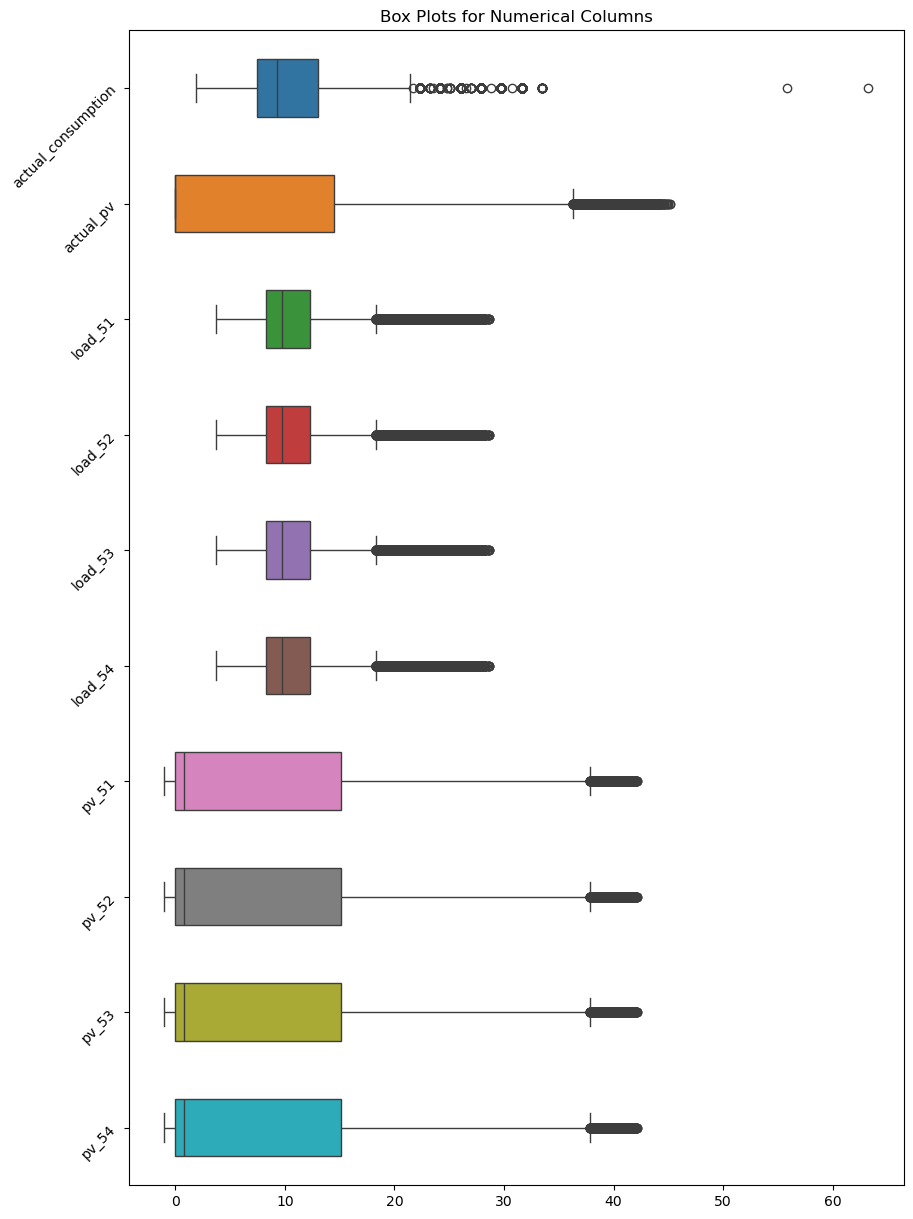

In [36]:
import matplotlib.pyplot as plt
import seaborn as sea

numerical_columns = ["actual_consumption", "actual_pv", "load_51", "load_52", "load_53", "load_54",
                     "pv_51", "pv_52", "pv_53", "pv_54"]

#Сбор данных для построения графика
data_for_plotting = df.select(*numerical_columns).collect()

# Prepare data for box plots
box_plot_data = {col_name: [row[col_name] for row in data_for_plotting] for col_name in numerical_columns}

# Generate box plots using seaborn
plt.figure(figsize=(10, 15))
sea.boxplot(data=box_plot_data, width=0.5, orient="h") # Change the orientation to horizontal
plt.title('Диаграмма "Ящика"')
plt.yticks(rotation=45, ha="right") # Rotate the y-axis labels instead of x-axis
plt.show()


In [37]:
# ВЫбросы есть везде, поэтому для обработки выбираем все столбцы
columns = ["actual_consumption", "actual_pv", "load_51", "load_52", "load_53", "load_54",
                     "pv_51", "pv_52", "pv_53", "pv_54"]

# общее количество строк до обработки
print('общее количество строк до обработки:', df.count())

#Рассчитываем нижний и верхний пределы на основе трех стандартных отклонений
std = {col_name: 3 * df.agg({col_name: "stddev"}).collect()[0][0] for col_name in columns}
mean = {col_name: df.agg({col_name: "mean"}).collect()[0][0] for col_name in columns}

# Фильтруем данные, сохраняя только значения в пределах 3 стд. отклонений
for col_name in columns:
    lower = mean[col_name] - std[col_name]
    upper = mean[col_name] + std[col_name]
    df = df.filter((df[col_name] >= lower) & (df[col_name] <= upper))

# общее количество строк после обработки
print('общее количество строк после обработки:', df.count())

общее количество строк до обработки: 91200
общее количество строк после обработки: 87843


## №4. расчетом статистических показателей признаков

In [39]:
# Считаем по всем столбцам
columns = ["actual_consumption", "actual_pv", "load_51", "load_52", "load_53", "load_54",
                     "pv_51", "pv_52", "pv_53", "pv_54"]
stat_df = df.describe(columns).show(truncate=False)


+-------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+
|summary|actual_consumption|actual_pv         |load_51           |load_52           |load_53           |load_54           |pv_51              |pv_52             |pv_53              |pv_54              |
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+
|count  |87843             |87843             |87843             |87843             |87843             |87843             |87843              |87843             |87843              |87843              |
|mean   |10.784381695281791|8.414725362378254 |10.677774540661696|10.656057204776577|10.651925416183513|10.666106015568685|8.232960121161895  |8.222055906337784 |8.206426481177742  |8.1875

## №5. визуализацией распределения наиболее важных признаков

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Distribution of actual_consumption')

Text(0.5, 0, 'actual_consumption')

Text(0, 0.5, 'Density')

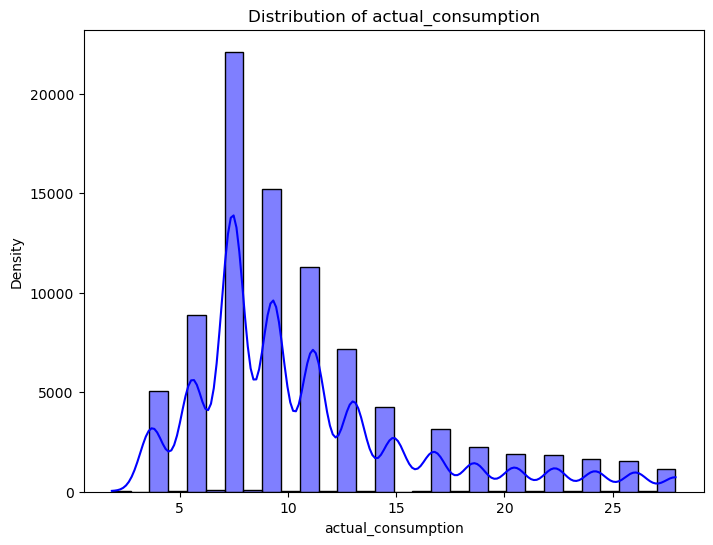

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Distribution of actual_pv')

Text(0.5, 0, 'actual_pv')

Text(0, 0.5, 'Density')

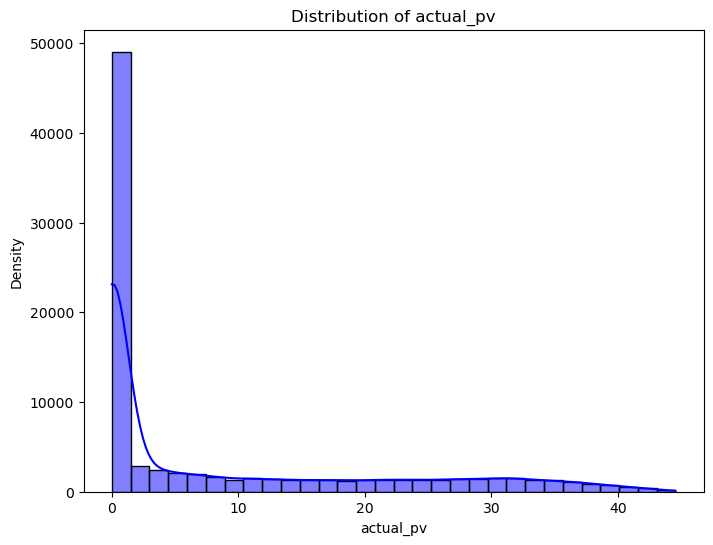

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Distribution of load_51')

Text(0.5, 0, 'load_51')

Text(0, 0.5, 'Density')

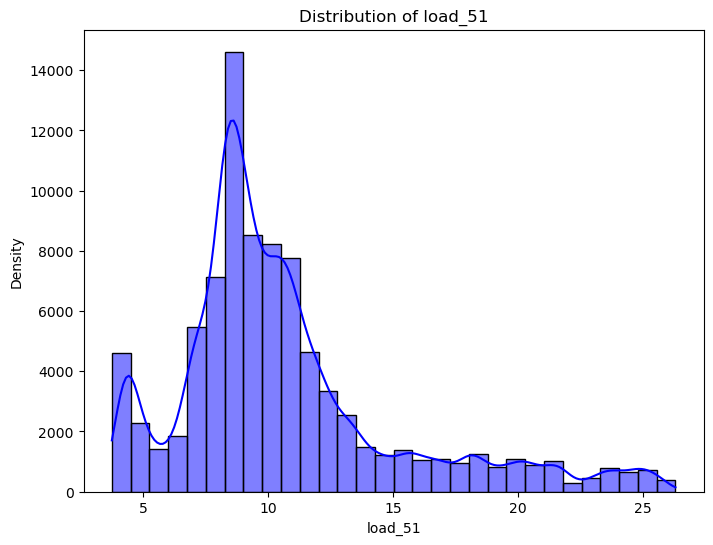

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Distribution of load_52')

Text(0.5, 0, 'load_52')

Text(0, 0.5, 'Density')

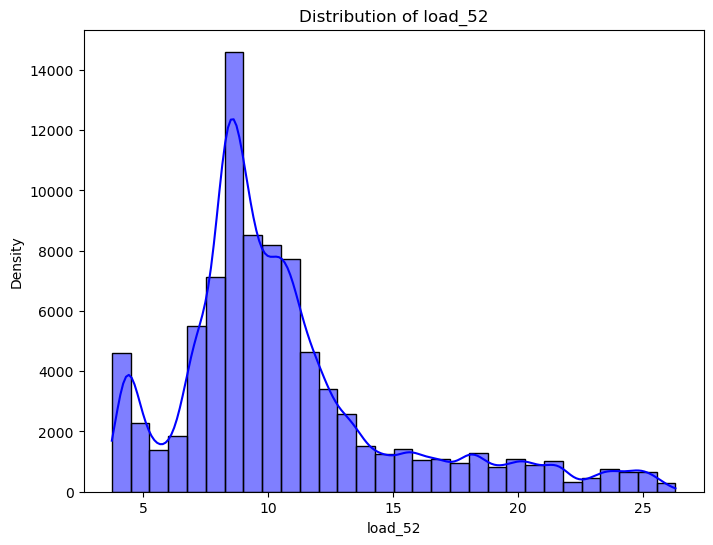

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Distribution of load_53')

Text(0.5, 0, 'load_53')

Text(0, 0.5, 'Density')

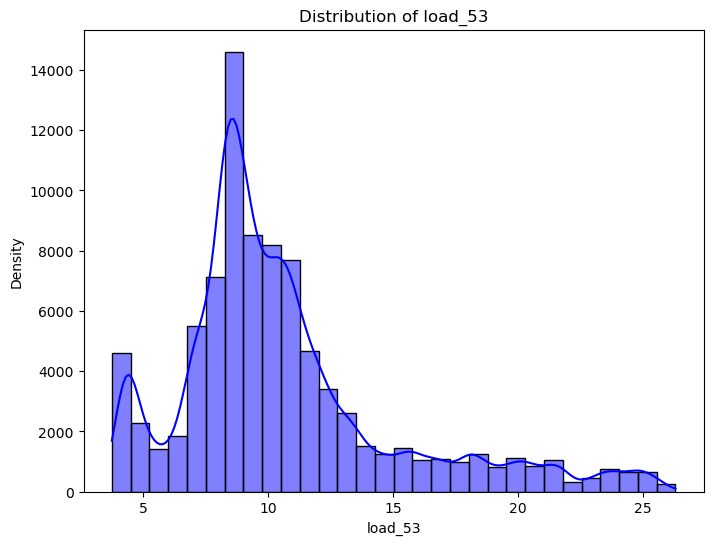

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Distribution of load_54')

Text(0.5, 0, 'load_54')

Text(0, 0.5, 'Density')

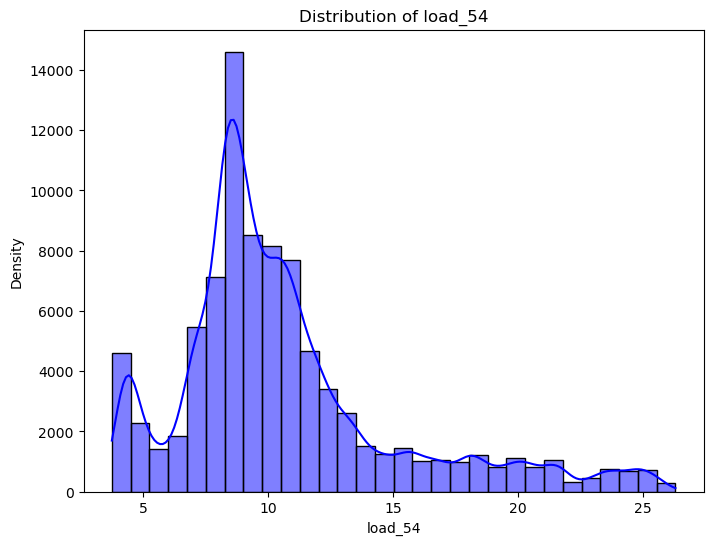

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Distribution of pv_51')

Text(0.5, 0, 'pv_51')

Text(0, 0.5, 'Density')

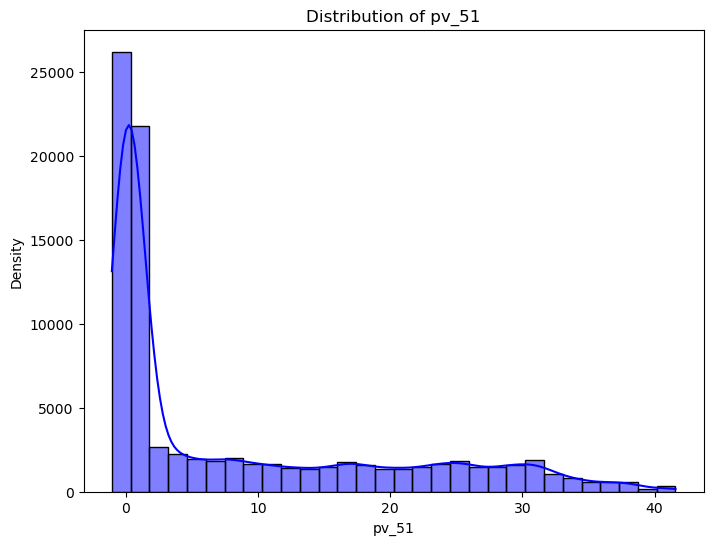

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Distribution of pv_52')

Text(0.5, 0, 'pv_52')

Text(0, 0.5, 'Density')

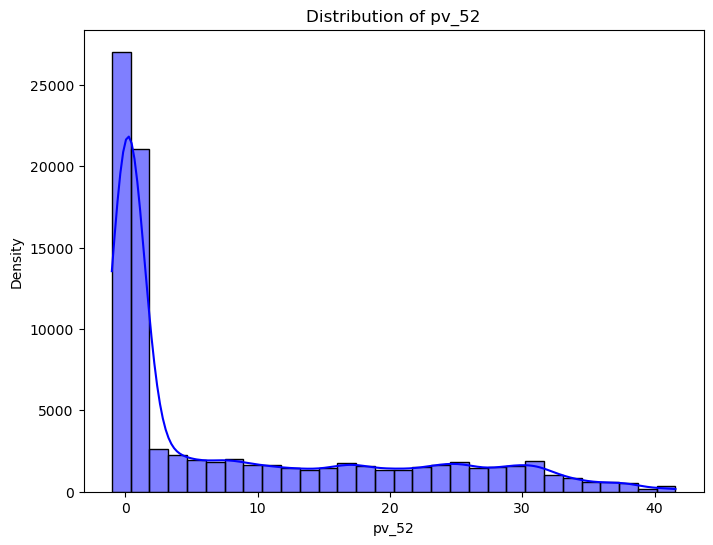

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Distribution of pv_53')

Text(0.5, 0, 'pv_53')

Text(0, 0.5, 'Density')

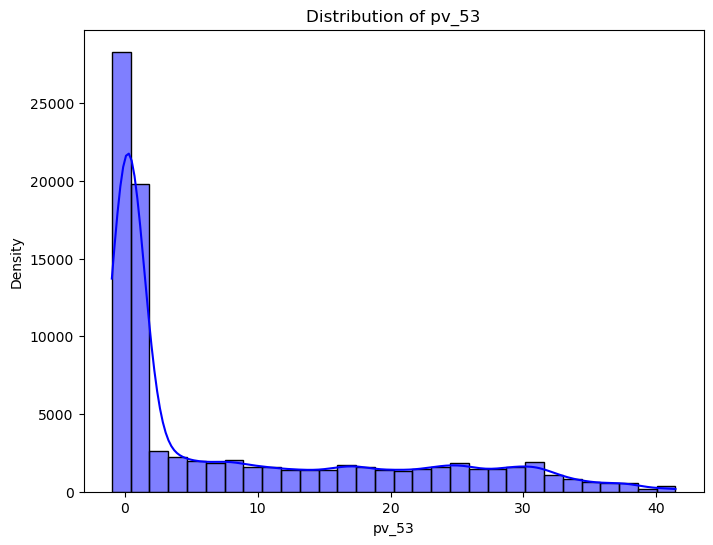

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Distribution of pv_54')

Text(0.5, 0, 'pv_54')

Text(0, 0.5, 'Density')

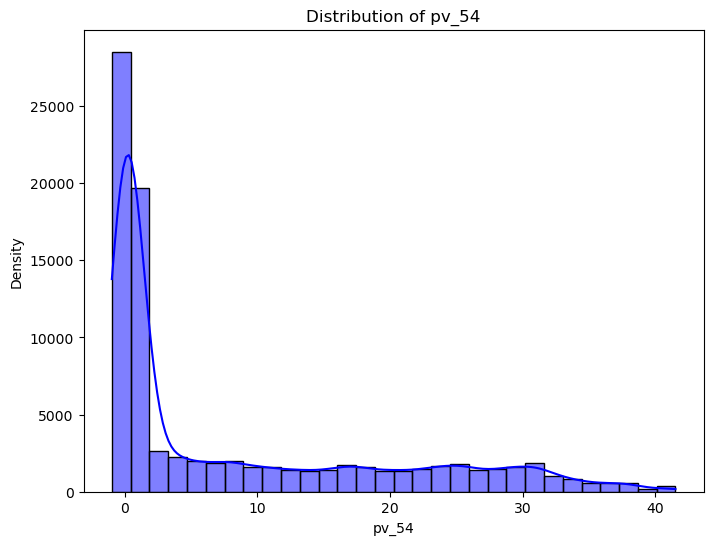

In [41]:
# Визуализация
columns = ["actual_consumption", "actual_pv", "load_51", "load_52", "load_53", "load_54",
                     "pv_51", "pv_52", "pv_53", "pv_54"]

for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    sea.histplot(df.select(column).rdd.flatMap(lambda x: x).collect(), bins=30, color='blue', kde=True) # Use sns.histplot instead of sns.distplot and add kde=True to show the density curve
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()


## №6. корреляций между признаками

<Figure size 1000x800 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f5d9f622f90>,
 [Text(0, 0, 'actual_consumption'),
  Text(1, 0, 'actual_pv'),
  Text(2, 0, 'load_51'),
  Text(3, 0, 'load_52'),
  Text(4, 0, 'load_53'),
  Text(5, 0, 'load_54'),
  Text(6, 0, 'pv_51'),
  Text(7, 0, 'pv_52'),
  Text(8, 0, 'pv_53'),
  Text(9, 0, 'pv_54')])

([<matplotlib.axis.YTick at 0x7f5d969f6b10>,
 [Text(0, 0, 'actual_consumption'),
  Text(0, 1, 'actual_pv'),
  Text(0, 2, 'load_51'),
  Text(0, 3, 'load_52'),
  Text(0, 4, 'load_53'),
  Text(0, 5, 'load_54'),
  Text(0, 6, 'pv_51'),
  Text(0, 7, 'pv_52'),
  Text(0, 8, 'pv_53'),
  Text(0, 9, 'pv_54')])

Text(0.5, 1.0, 'Correlation Matrix')

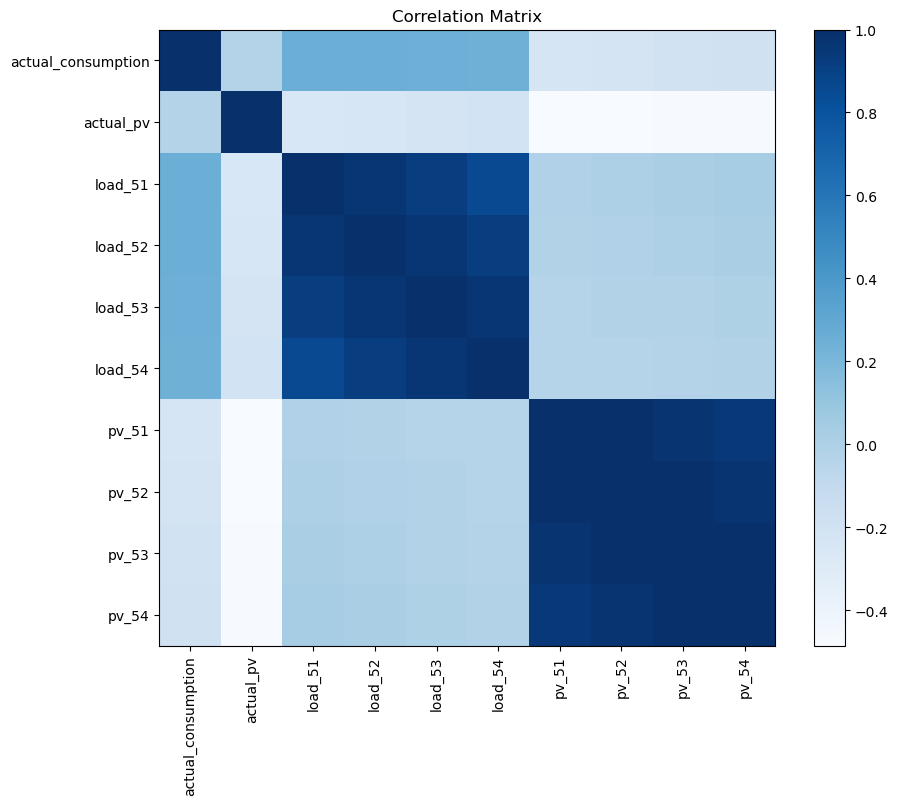

In [47]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
columns = ["actual_consumption", "actual_pv", "load_51", "load_52", "load_53", "load_54",
                     "pv_51", "pv_52", "pv_53", "pv_54"]

#Собираем объекты в один столбец
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
assembled_df = assembler.transform(df)

# Считаем кор. матрицу
cor_m = Correlation.corr(assembled_df, "features").head()

#Извлекаем матрицу в виде массива NumPy
cor_matrix = cor_m[0].toArray()

#График матрицы корреляции
plt.figure(figsize=(10, 8))
plt.imshow(cor_matrix, cmap="Blues", interpolation="none")
plt.colorbar()
plt.xticks(range(len(columns)), columns, rotation=90)
plt.yticks(range(len(columns)), columns)
plt.title("Correlation Matrix")
plt.show()

In [48]:
# Останавливаем сессию Spark
spark.stop()